# Analysis - Hashtag

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd


from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality
from utils.util import chainer

import core.config as conf

In [2]:
client

Client Scheduler: tcp://127.0.0.1:34211 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load data

In [64]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)
df = ori_df[['hashtags', 'tweet_type', 'language', 'tweet_id', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp']]
df = df.dropna()

print('total exampls with hastags: ', len(df['hashtags'].dropna()))

number of rows: 3033347
total exampls with hastags:  597297


In [65]:
df['hashtags_list'] = df['hashtags'].str.split('\t')
df['hashtags_cnt'] = df['hashtags'].str.count('\t')
df['hashtags_cnt'] = df['hashtags_cnt'].astype(int) + 1

print('max hashtag count: ', df['hashtags_cnt'].compute().max())
print('min hashtag count: ', df['hashtags_cnt'].compute().min())

max hashtag count:  40
min hashtag count:  1


In [66]:
df = pd.DataFrame({
    'id': np.repeat(df.index.to_series().compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'tweet_type': np.repeat(df['tweet_type'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'language': np.repeat(df['language'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'retweet_timestamp': np.repeat(df['retweet_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'retweet_with_comment_timestamp': np.repeat(df['retweet_with_comment_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'like_timestamp': np.repeat(df['like_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'reply_timestamp': np.repeat(df['reply_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'hashtags': chainer(df['hashtags'].compute().to_pandas())
})

df = dask_cudf.from_cudf(df, npartitions=2)
print('the number of hashtags: ', len(df))

the number of hashtags:  1202007


In [67]:
df, _ = factorize_small_cardinality(df, 'hashtags')
df, _ = factorize_small_cardinality(df, 'language')

In [68]:
print('total rows: ', len(df))
print('total unique hashtags: ', len(df['hashtags'].unique().compute()))

total rows:  1202007
total unique hashtags:  324268


## 1. The popularity of each hashtag

In [94]:
hashtag_cnt = sorted(df['hashtags_encode'].compute().value_counts().sort_values(), reverse=True)

In [99]:
hashtag_cnt[:10]

[12873, 4937, 4104, 3705, 3049, 2802, 2237, 2177, 1994, 1891]

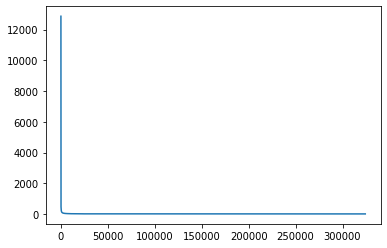

In [95]:
plt.clf()
plt.plot(hashtag_cnt)
plt.show()

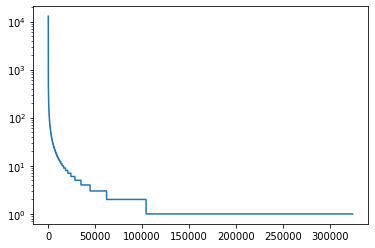

In [96]:
# log scale
plt.clf()
plt.yscale('log')
plt.plot(hashtag_cnt)
plt.show()